## Set up

In [1]:
%matplotlib notebook

In [130]:
from qa import metrics, plots
from orca.metadata import pathsmanagers
from datetime import datetime, date
import os.path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import casatools
from collections import Counter

In [133]:
tb = casatools.table()

## Find data and calibration files

In [3]:
%cd /lustre/mmanders/exoplanet

/lustre/mmanders/exoplanet


In [4]:
%ls 

BCAL/  orca_test/  orca_testwpm/  peeling_solutions/  processing/  RFIsprint/


In [14]:
user = 'mmanders'
pm_20200117 = pathsmanagers.OfflinePathsManager(utc_times_txt_path='/lustre/data/exoplanet_20200117/utc_times.txt',
                                                dadafile_dir='/lustre/data/exoplanet_20200117',
                                                working_dir=f'/lustre/{user}/exoplanet/processing',
                                                gaintable_dir=f'/lustre/{user}/exoplanet/processing/BCAL')
spws = list(range(2, 8))
start_time = datetime(2020, 1, 17, 8, 0, 0)
end_time = datetime(2020, 1, 17, 9, 0, 0)

In [15]:
pm = pm_20200117.time_filter(start_time=start_time, end_time=end_time)
msfiles = [pm.get_ms_path(t, f'{s:02d}') for t in pm.utc_times_mapping.keys() for s in spws if os.path.exists(pm.get_ms_path(t, f'{s:02d}'))]
bpfiles = [pm.get_gaintable_path(date(2020,1,21), f'{s:02d}', 'bcal') for s in spws ]

In [24]:
print(f"{len(msfiles)} ms data files found. First and last MS data files:")
print([msf.split('/')[-1] for msf in [msfiles[0],msfiles[-1]]])

print(f"{len(bpfiles)} bandpass calibration files found:")
print([bpf.split('/')[-1] for bpf in bpfiles])

1428 ms data files found. First and last MS data files:
['02_2020-01-17T08:08:34.ms', '07_2020-01-17T08:59:55.ms']
6 bandpass calibration files found:
['02.bcal', '03.bcal', '04.bcal', '05.bcal', '06.bcal', '07.bcal']


## Flagging summary

### Flagging by channel (over all spw)

<IPython.core.display.Javascript object>


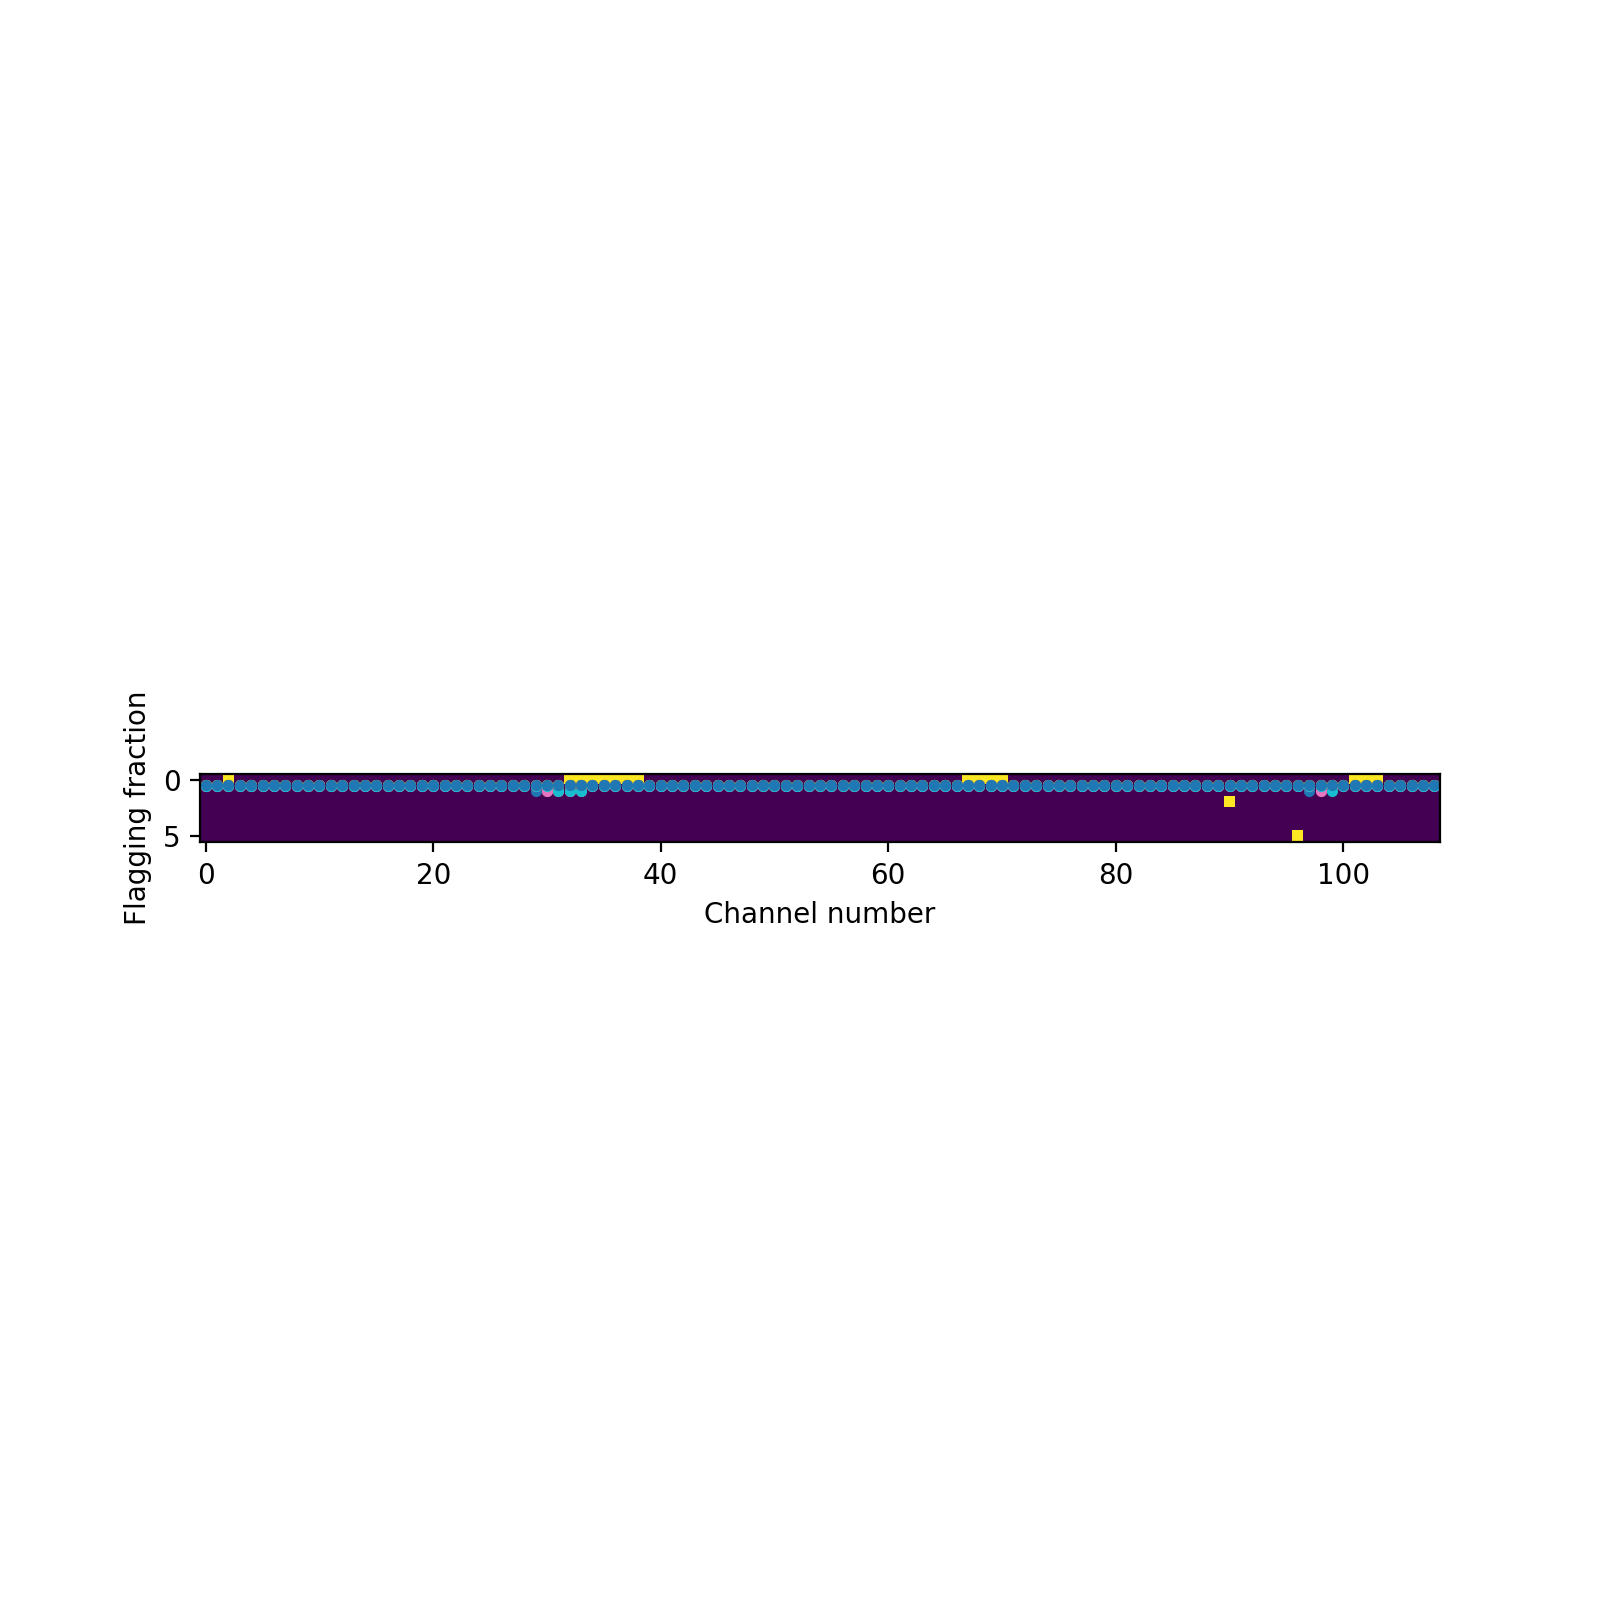

Text(0, 0.5, 'Flagging fraction')

In [136]:
# Plot some fraction of all ms data files
fracs = [metrics.flagfrac_chans(msf) for msf in msfiles[::len(msfiles)//10]]

fig = plt.figure(figsize=(8,8))
for frac in fracs:
    plt.plot(range(109), frac, '.')
plt.xlabel("Channel number")
plt.ylabel("Flagging fraction")

### Flagging over antenna

Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol


<IPython.core.display.Javascript object>


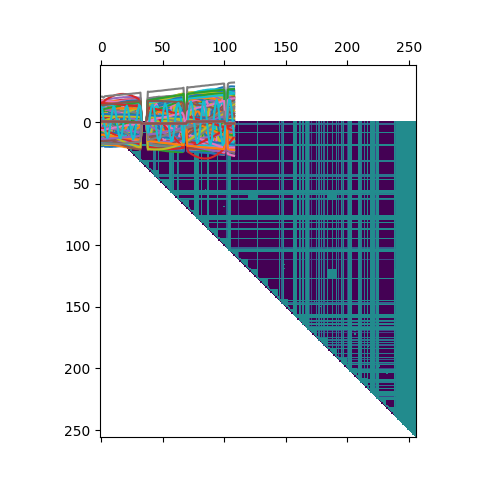

In [58]:
corrs = plots.corr_flagfrac(msfiles[0], showplot=False, saveplot=False)

fig = plt.figure(figsize=(8,8))
for msfile in msfiles[1::len(msfiles)//10]:
    corrs += plots.corr_flagfrac(msfile, showplot=False, saveplot=False)
corrs /= len(msfiles)
im = plt.matshow(corrs, norm=LogNorm(vmin=1.e-4, vmax=1))
plt.colorbar()

<IPython.core.display.Javascript object>


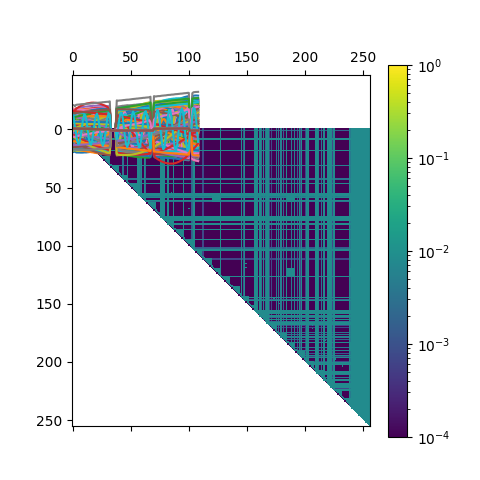

In [59]:
im = plt.matshow(corrs, norm=LogNorm(vmin=1.e-4, vmax=1))
plt.colorbar()

## Bandpass calibration

In [193]:
bps = []
snrs = []
snrm = []
for bpfile in bpfiles:
    tb.open(bpfile)
    bps.append(tb.getcol('CPARAM'))
    snr = tb.getcol('SNR')
    tb.close()
    snrs.append(snr)
    snrm.append(snr.mean(axis=2))
bpa = np.concatenate(bps, axis=1)
bpaa = np.abs(bpa)
snra = np.concatenate(snrs, axis=1)
snrm = np.array(snrm)
nspw, npol, nant = snrm.shape
npol, nch, nant = snr.shape

In [194]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, squeeze=True)
ax1.plot(snrm[:, 0])
ax1.set_ylabel('Pol 0 (mean per spw)')
ax2.plot(snrm[:, 1])
ax2.set_xlabel('SPW number')
ax2.set_ylabel('Pol 1 (mean per spw)')
ax1.set_title("Bandpass solution SNR per spw")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Bandpass solution SNR per spw')

In [195]:
thresh = 0.7
wspw, wpol, want = np.where(snrm < thresh*np.median(snrm))
if len(wspw):
    for k, v in Counter(wspw).items():
        print(f'SPW {k} has {v} poor solutions')
if len(wpol):
    for k, v in Counter(wpol).items():
        print(f'Pol {k} has {v} poor solutions')
if len(want):
    for k, v in Counter(want).items():
        print(f'Ant {k} has {v} poor solutions')
        
bad = np.zeros(shape=(npol, nspw, nant), dtype=bool)
bad[wpol, wspw, want] = True

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,5), sharex='col')
ax1.imshow(bad[0])
ax1.set_ylabel("Pol 0 SPW")
ax2.imshow(bad[1])
ax2.set_ylabel("Pol 0 SPW")
ax2.set_xlabel("Antenna")

SPW 0 has 30 poor solutions
SPW 2 has 2 poor solutions
SPW 5 has 1 poor solutions
Pol 0 has 17 poor solutions
Pol 1 has 16 poor solutions
Ant 2 has 2 poor solutions
Ant 32 has 2 poor solutions
Ant 33 has 2 poor solutions
Ant 34 has 2 poor solutions
Ant 35 has 2 poor solutions
Ant 36 has 2 poor solutions
Ant 37 has 2 poor solutions
Ant 38 has 2 poor solutions
Ant 67 has 2 poor solutions
Ant 68 has 2 poor solutions
Ant 69 has 2 poor solutions
Ant 70 has 2 poor solutions
Ant 101 has 2 poor solutions
Ant 102 has 2 poor solutions
Ant 103 has 2 poor solutions
Ant 90 has 2 poor solutions
Ant 96 has 1 poor solutions


<IPython.core.display.Javascript object>

Text(0.5, 0, 'Antenna')

In [196]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, squeeze=True)
ax1.plot(bpaa[0, :, :], '.')
ax2.set_xlabel('Channel')
ax1.set_ylabel('Pol 0 amplitude')
ax2.plot(bpaa[1, :, :], '.')
ax2.set_ylabel('Pol 1 amplitude')
ax1.set_title("Bandpass amplitude")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Bandpass amplitude')

Channel 0 has 124 poor solutions
Channel 1 has 124 poor solutions
Channel 2 has 124 poor solutions
Channel 3 has 124 poor solutions
Channel 4 has 124 poor solutions
Channel 5 has 124 poor solutions
Channel 6 has 124 poor solutions
Channel 7 has 124 poor solutions
Channel 8 has 124 poor solutions
Channel 9 has 124 poor solutions
Channel 10 has 124 poor solutions
Channel 11 has 124 poor solutions
Channel 12 has 124 poor solutions
Channel 13 has 124 poor solutions
Channel 14 has 124 poor solutions
Channel 15 has 124 poor solutions
Channel 16 has 124 poor solutions
Channel 17 has 124 poor solutions
Channel 18 has 124 poor solutions
Channel 19 has 124 poor solutions
Channel 20 has 124 poor solutions
Channel 21 has 124 poor solutions
Channel 22 has 124 poor solutions
Channel 23 has 124 poor solutions
Channel 24 has 124 poor solutions
Channel 25 has 124 poor solutions
Channel 26 has 124 poor solutions
Channel 27 has 124 poor solutions
Channel 28 has 124 poor solutions
Channel 29 has 124 poor 

<IPython.core.display.Javascript object>


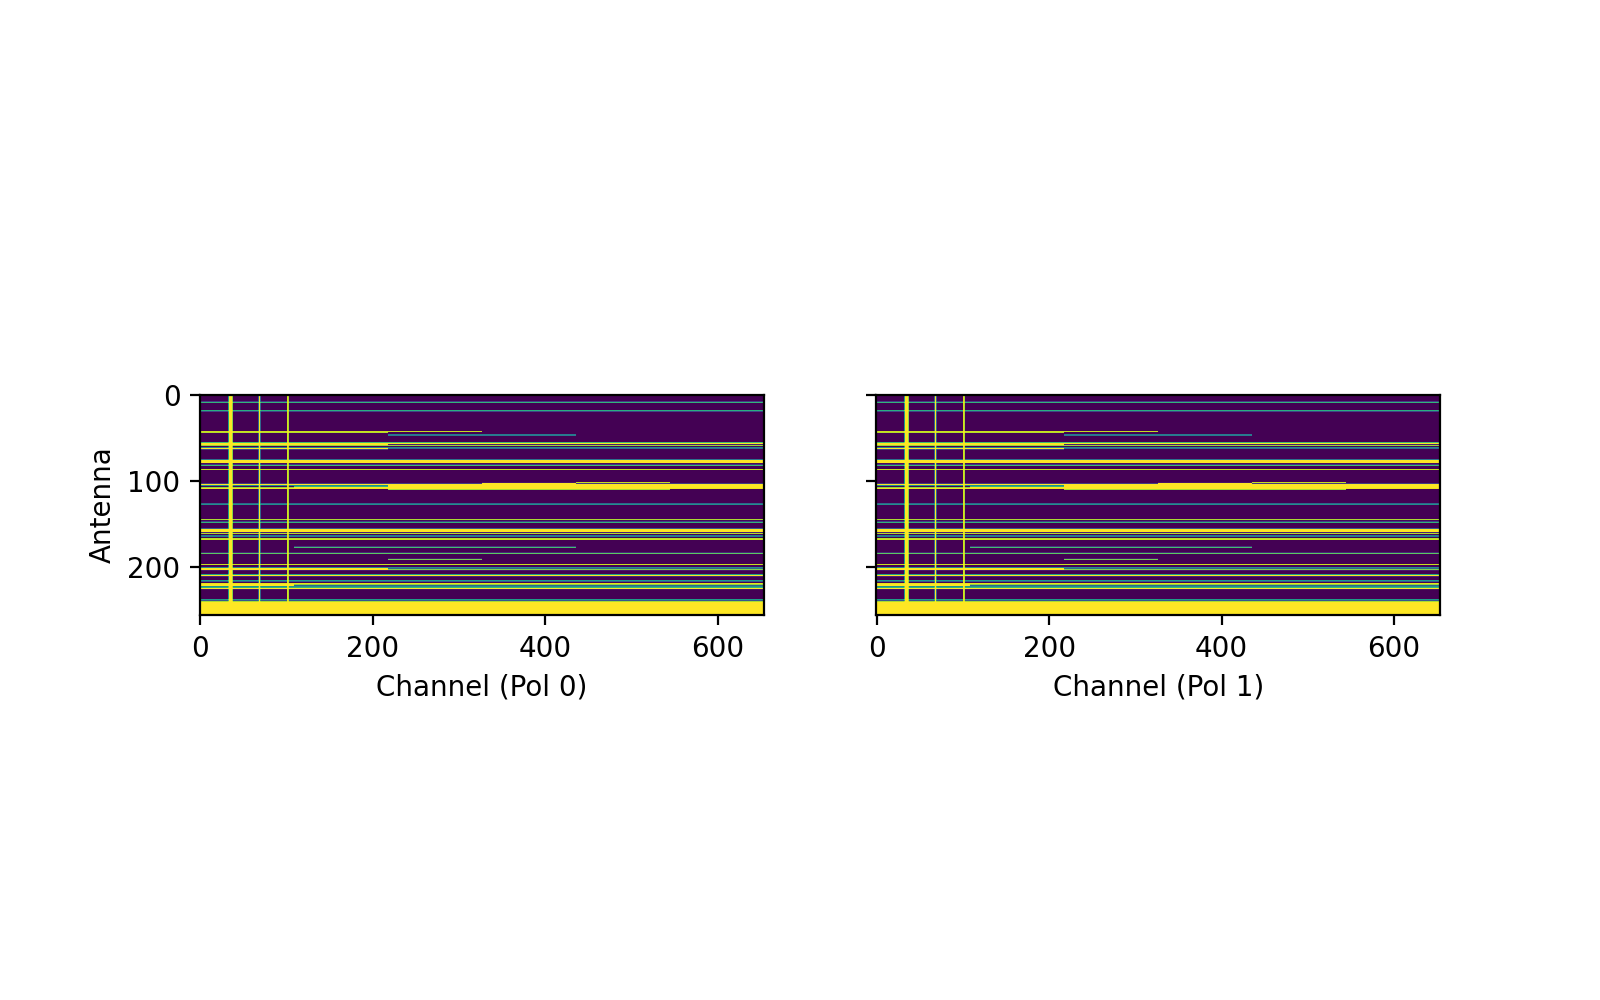

Text(0.5, 0, 'Channel (Pol 1)')

In [212]:
thresh = 0.1
wpol, wch, want = np.where(bpaa < thresh*np.median(bpaa))
if len(wch):
    for k, v in Counter(wch).items():
        print(f'Channel {k} has {v} poor solutions')
if len(want):
    for k, v in Counter(want).items():
        print(f'Ant {k} has {v} poor solutions')
if len(wpol):
    for k, v in Counter(wpol).items():
        print(f'Pol {k} has {v} poor solutions')

print(Counter(want))
        
bad = np.zeros(shape=(npol, nant, nch*nspw), dtype=bool)
bad[wpol, want, wch] = True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), sharey='row')
ax1.imshow(bad[0])
ax1.set_ylabel("Antenna")
ax1.set_xlabel("Channel (Pol 0)")
ax2.imshow(bad[1])
ax2.set_xlabel("Channel (Pol 1)")

In [198]:
bpaa.shape

(2, 654, 256)

In [201]:
wch

array([  0,   0,   0, ..., 653, 653, 653])